<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações 

In [205]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [148]:
!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/

# **Coleta de dados do Kaglle**

In [206]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [207]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


# **###  Download dos dados / descompactando os dados**

In [ ]:
#!kaggle datasets download tanyadayanand/geological-image-similarity
#! unzip -qq  geological-image-similarity

In [208]:
!kaggle datasets download fabiobasson/geologicalsimilarity
! unzip -qq  geologicalsimilarity

  0% 0.00/1.31M [00:00<?, ?B/s]
100% 1.31M/1.31M [00:00<00:00, 43.2MB/s]


# ** Criação da estrutura **

In [209]:
andesite_dir = glob.glob('andesite/*.jpg');gneiss_dir = glob.glob('gneiss/*.jpg')
gneiss_dir= glob.glob('marble/*.jpg');quartzite_dir = glob.glob('quartzite/*.jpg')
rhyolite_dir = glob.glob('rhyolite/*.jpg');
schist_dir = glob.glob('schist/*.jpg')
#print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))


In [185]:
#from skimage.io import imread_collection

#your path 
#col_dir = 'col_df/*/*.jpg'

#creating a collection with the available images
#col = imread_collection(col_dir)

In [196]:
#col_reshape = col[0].reshape(col[0].shape[0],-1)
#col_reshape

array([[100, 109, 108, ...,  96, 105, 102],
       [103, 112, 111, ...,  89,  98,  95],
       [ 98, 107, 106, ...,  96, 105, 102],
       ...,
       [103, 105, 104, ...,  93, 102,  97],
       [ 99, 101, 100, ...,  99, 108, 103],
       [ 91,  93,  92, ...,  97, 106, 101]], dtype=uint8)

# **Nomes das Classes**
# andesite = 0  # gneiss =1 # marbler = 2 # quartzite = 3 # rhyolite = 4  # schist = 5 


In [210]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']

# label =[0,1,2,3,4,5]

In [211]:
andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

for i in andesite_dir:
    andesite_df.append([i,class_names[0]])
for j in gneiss_dir:
   gneiss_df.append([j,class_names[1]])
for l in marble_dir:
    marble_df.append([l,class_names[2]])
for m in quartzite_dir:
    quartzite_df.append([m,class_names[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,class_names[4]])
for o in schist_dir:
    schist_df.append([o,class_names[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)

1232

In [212]:
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,rhyolite/0ONXT.jpg,rhyolite
1,andesite/0TLMK.jpg,andesite
2,schist/1VIQN.jpg,schist
3,marble/1B6ME.jpg,gneiss
4,andesite/0N3JV.jpg,andesite
...,...,...
1227,rhyolite/1WQX5.jpg,rhyolite
1228,marble/1KGTP.jpg,gneiss
1229,quartzite/0SG3W.jpg,quartzite
1230,schist/0TZG8.jpg,schist


#  Conhecendo os dados de imagem

In [213]:
from matplotlib import image
from matplotlib import pyplot
# Carregando imagem como um array NumPy:
data = image.imread("gneiss/0QTQE.jpg")
# Imprimindo o conteúdo do array NumPy:

uint8
(28, 28, 3)
251
32


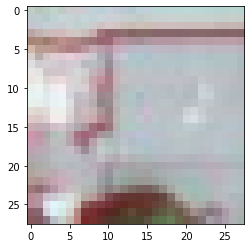

In [214]:
# Imprimindo as propriedades do array de pixels:
print(data.dtype)
print(data.shape)
print(data.max())
print(data.min())

# Exibindo o array de pixels como uma imagem:
pyplot.imshow(data)

In [ ]:
from numpy import asarray
image = Image.open("gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
print(pixels)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

# **Normalização dos dados**

In [18]:
from sklearn import preprocessing

sca = preprocessing.StandardScaler()
data_df = sca.fit_transform(data_df)
data_df=pd.DataFrame(data_df)

ValueError: ignored

# **Separação das amostras**

In [217]:
X = data_df.drop(columns='label')
y = data_df.path

# **Criando o Dataframe**

In [218]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=44)

In [225]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(985, 1)
(247, 1)
(985,)
(247,)


# **Explorando os dados**

# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

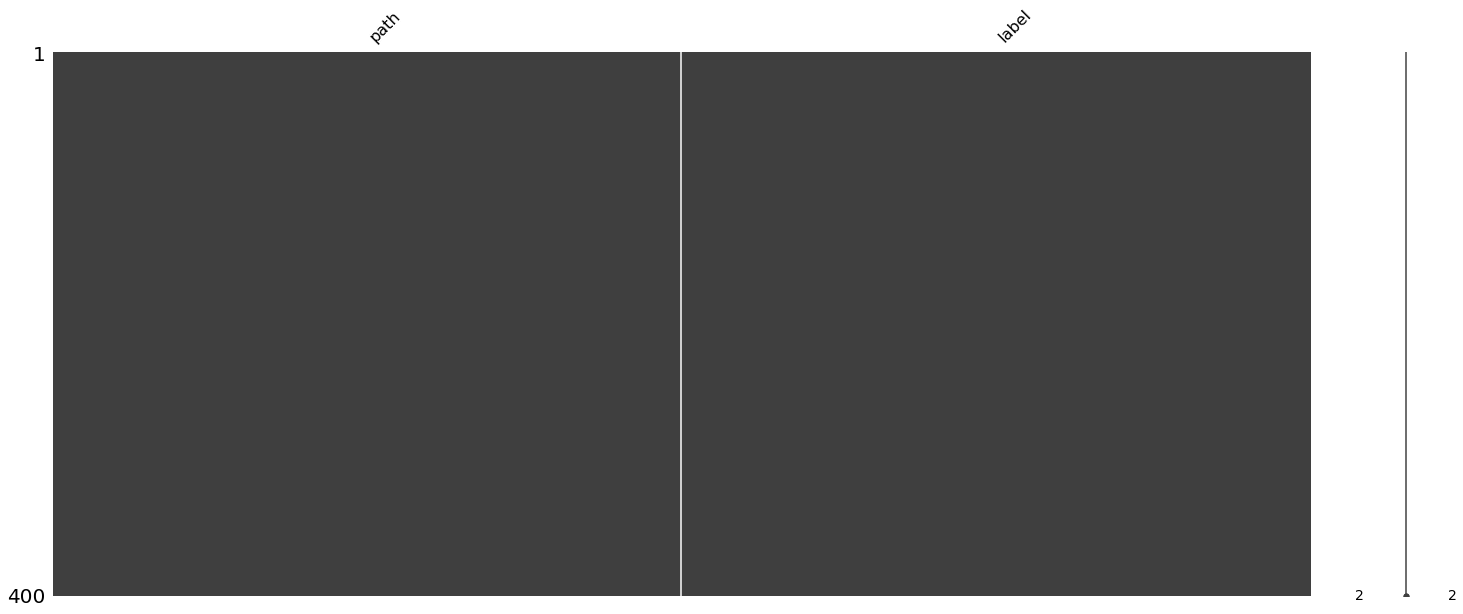

In [219]:
import missingno as msno
ax = msno.matrix(data_df.sample(400))

In [ ]:
#! pip install pandas-profiling==2.8.0
#from pandas_profiling import ProfileReport
#ProfileReport (data_df)

# **Data Argumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [220]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [221]:
IMG_SHAPE = 28
BATCH_SIZE = 20

In [222]:
datagen = ImageDataGenerator(rescale=1./255,
                            featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip =False , 
                            validation_split=0.2)

In [223]:
train_generator = datagen.flow_from_dataframe(data_df,
                                              x_col='path',
                                              y_col='label',
                                              images_size=(28,28),
                                              #class_mode='binary',
                                              subset='training')

validation_generator = datagen.flow_from_dataframe(data_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   images_size=(28,28),
                                                   #class_mode='binary',
                                                   subset='validation')

## Duvidas - Existe esse codigo abaixo

test_generator = datagen.flow_from_dataframe(data_df,
                                             x_col='path',
                                             y_col='label',
                                             images_size=(28,28),
                                             #class_mode='binary',
                                             )

Found 986 validated image filenames belonging to 6 classes.
Found 246 validated image filenames belonging to 6 classes.
Found 1232 validated image filenames belonging to 6 classes.


In [226]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

TypeError: ignored

# **Pre Processamento dos dados**

# **Criar o modelo**

In [ ]:
inputs = tf.keras.Input(shape=(256, 256,3))
#x = augmented_images(inputs) # como conserto e passo isso
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1)
])

# **Compilando o Modelo**

In [39]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['accuracy'])

In [40]:
model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      147520    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [41]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        #restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        save_best_only=True,
    ),

]

# **Avaliar o modelo**

In [42]:
history = model.fit(train_generator,
                               epochs=5,
                               #verbose=0,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               #workers=4,
                               use_multiprocessing=True,
                               validation_data=validation_generator)

Epoch 1/5
31/31 [==============================] - 572s 19s/step - loss: 0.5295 - accuracy: 0.8231 - val_loss: 0.4558 - val_accuracy: 0.8333
Epoch 2/5
31/31 [==============================] - 594s 19s/step - loss: 0.4540 - accuracy: 0.8333 - val_loss: 0.4518 - val_accuracy: 0.8333
Epoch 3/5
31/31 [==============================] - 574s 18s/step - loss: 0.4517 - accuracy: 0.8333 - val_loss: 0.4512 - val_accuracy: 0.8333
Epoch 4/5
31/31 [==============================] - 579s 18s/step - loss: 0.4512 - accuracy: 0.8333 - val_loss: 0.4507 - val_accuracy: 0.8333
Epoch 5/5
31/31 [==============================] - 577s 18s/step - loss: 0.4511 - accuracy: 0.8333 - val_loss: 0.4514 - val_accuracy: 0.8333


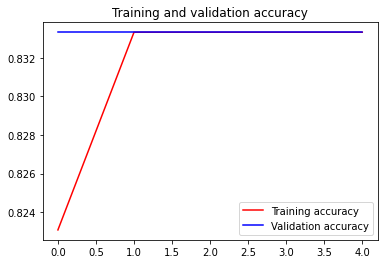

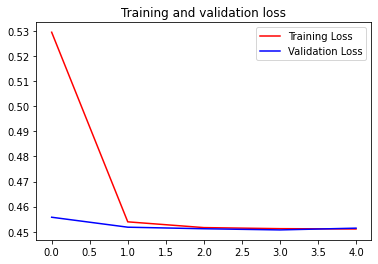

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Otimizar o modelo**

# **Avaliar o Modelo**

In [ ]:
model = tf.keras.models.load_model("best_model.h5")

val_acc = model.evaluate(test_generator)[1]
print("validation_accuracy: " + str(val_acc))

29/39 [=====================>........] - ETA: 43s - loss: 0.4556 - accuracy: 0.8333